# This script is for analyzing h5 files (Stalefish output)

The script has many functions but only four general purposes: 

1) read in h5 files 

2) add scaling either within-box, within-slice, or within-brain

3) interpolates data to scale size of slice (1d interps for curve cortex df.column.values / various methods for hand-drawn areas

4) combines brains within conditions and compares them across condition 

In [1]:
# you can get in the stalefish directory or wherever your files are,the directory of your data to read in the h5's
#cd Stalefish/ucr

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from matplotlib.patches import Polygon
import matplotlib as mpl
import pandas as pd


import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale,scale,normalize

from numpy import polyder
import skimage as sk
import math

import scipy as sc
from scipy import interpolate 


from skimage import measure 
from skimage import io
from skimage import feature
from skimage import filters

from skimage.morphology import medial_axis, skeletonize, skeletonize_3d
from skimage.morphology import skeletonize_3d
from skimage import data
from skimage.util import invert

from PIL import ImageFilter
from PIL import Image, ImageDraw

C:\Users\Mackenzie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In the current state some of the functions are outside the classs and some of them are in the class. I think it would be best to either put all of the functions in or out of the class. 

Either way this all needs to be packaged up so users can just call functions 

In [5]:
# Within-Box Scaling
def single_scaling(box_frame):
    box_frame['box_std_dev'] = box_frame[0].std() 
    box_frame['box_z_score'] = (box_frame[0] - box_frame[0].mean()) / (box_frame[0].std())
    box_frame['box_min_max'] = minmax_scale(box_frame[0])
    box_frame['box_mean_center'] = scale(box_frame[0])
    box_frame['box_background_norm'] = box_frame[0] / background_level
    box_frame['box_signal_sum'] = np.array(box_frame[0])
    
    

# Within-Slice Scaling
def slice_scale(single_slice_data):
    raw_mean = single_slice_data.raw_mean
    single_slice_data['slice_min_max'] = minmax_scale(raw_mean)
    single_slice_data['slice_z_score'] = (raw_mean - raw_mean.mean()) / (raw_mean.std())
    single_slice_data['slice_mean_center'] = scale(raw_mean)
    single_slice_data['slice_background_norm'] = raw_mean / background_level
    # so you might want to get rid of the within-box mean_max now? 
    # keep in mind that the within-box scaling, is the mean of those min_max scaled within box
    return single_slice_data


In [6]:
class stalefish:
    def __init__(self,filename):
        self.filename = filename
        h5_file = h5py.File(filename)
        background_level = 10  #h5_file['something']['something'] #select a background level, this will be automated soon 
        print('Your file:',filename, 'has',list(h5_file['nframes']),'slices')
        print('if you would like to explore scaling options:')
        
        
    def box_scaling(self): 
        slice_list = list(h5_file)
        slice_list = slice_list[:-1] #get rid of nframes
        all_slices_df_list = []
        

        
        for a_slice in slice_list: #iterate through all slices in the h5
            this_slice = h5_file[a_slice]

            box_name_list = []
            box_mean_list = []
            z_score_mean_list_by_box = []  #empty lists to fill with adjusted mean values
            mean_box_min_max = []
            mean_background_division = []
            mean_box_from_h5 = []
            box_iter_name = []
            box_sum = []
            box_length = []

            bad_box_list = ['class', 'fitted', 'fitted_offset', 'fitted_rotated', 'means', 'means_autoscaled', 'nboxes',
                 'sbox_centers', 'sbox_linear_distance','sboxes']


            nboxes = list(h5_file[a_slice]['nboxes'])
            nbox_val = nboxes[0]
            box_count = 0
            
            for i in range(0,nbox_val): # iterate through all boxes of a single slice
            
                name_of_box = ('box{0}'.format(i)) 
            
                if name_of_box not in bad_box_list:  
                    this_box = (h5_file[a_slice])[name_of_box]
                    df_this_box = pd.DataFrame(np.array(this_box)) 
        
                    single_scaling(df_this_box) 
        
                    # this block of code fills up the empty lists above, making lists of all boxes which contain   
                    # the mean of a single way of scaling per box 
                    box_name_list.append(str(name_of_box))
                    box_mean_list.append(df_this_box[0].mean())
                    z_score_mean_list_by_box.append(df_this_box['box_z_score'].mean())
                    mean_box_min_max.append(df_this_box['box_min_max'].mean())
                    mean_background_division.append(df_this_box['box_background_norm'].mean())
                    box_sum.append(df_this_box['box_signal_sum'].sum())
                    box_length.append(len(df_this_box['box_signal_sum']))
                    box_iter_name.append(box_count)
                    box_count += 1
           
                    a = list(h5_file[a_slice]['means'])


            df_means_from_scaling = pd.DataFrame({'slice':str(a_slice),'box_name':box_name_list,'raw_mean':box_mean_list,
                                                  'z_score':z_score_mean_list_by_box,'min_max':mean_box_min_max,
                                                  'bckrnd_div':mean_background_division,
                                                  'box_number':box_iter_name,'box_sig_sum':box_sum,
                                                  'box_len':box_length}) #it doesn't look like means is in order?
    
            df_means_from_scaling['sbox_lin_dist'] = h5_file[a_slice]['sbox_linear_distance']
            #df_means_from_scaling['means'] = h5_file[a_slice]['means']
   
            # need to make a per-slice key that shows the background 
    
            all_slices_df_list.append(df_means_from_scaling)
        
            all_box_frames = pd.concat(all_slices_df_list)
        
        return all_box_frames
    
        
    # THEN WITHIN BRAIN 
        
        
    #def scale_hand_drawn_area(self):
        # or could make this its own class with other functions???/
    

# Load in your file and add within-box and within-slice scaling

In [7]:
filename = 'V_Id2_1 _1.h5'
h5_file = h5py.File(filename)
background_level = .85

one_file = stalefish(filename)

Your file: V_Id2_1 _1.h5 has [47] slices
if you would like to explore scaling options:


In [9]:
one_file_scale = one_file.box_scaling() # This function will take a few minutes, as it is adding a lot of scaling options

In [11]:
slice_scale_frame = one_file_scale.groupby('slice').apply(slice_scale) # this one is quick however 

In [12]:
# add some within-brain scaling, such as applying a gaussian kernal to the whole thing

In [13]:
#slice_scale_frame.head()

# Try out some different within-box or within-slice scaling methods

Keep in mind that we have stored sbox_linear_values, so regenerating the true length of the slices is still possible!! 

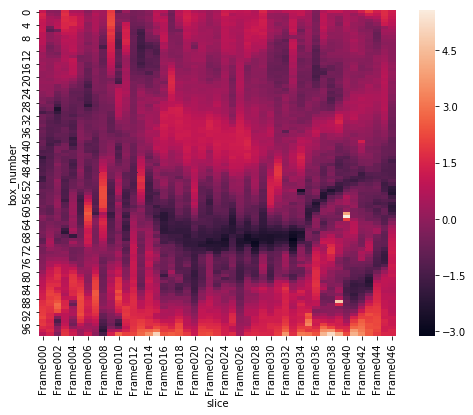

In [14]:
# Within-Slice (Mean Centering)
data_pivot = slice_scale_frame.pivot('box_number','slice','slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

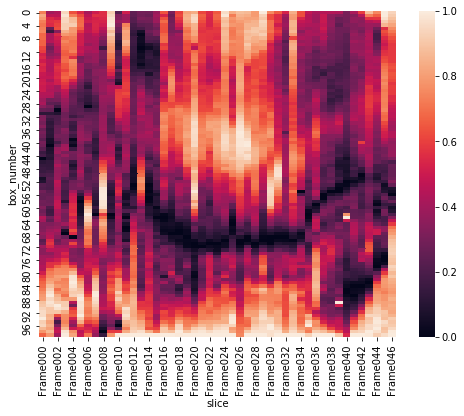

In [15]:
# Within-Slice (Min Max Scaling)
data_pivot = slice_scale_frame.pivot('box_number','slice','slice_min_max')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

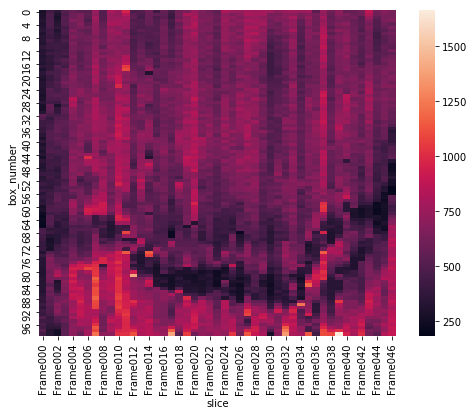

In [16]:
# Within-Box (Signal Sum)
data_pivot = one_file_scale.pivot('box_number','slice','box_sig_sum')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

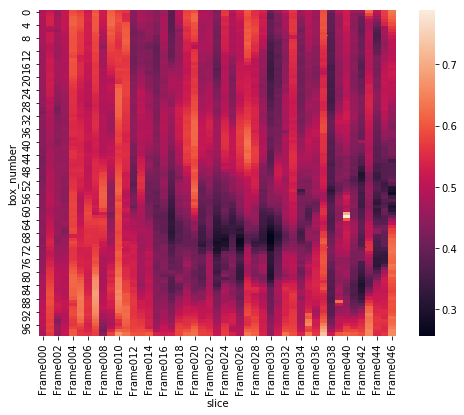

In [43]:
# Within-Box (Raw Mean of Box)
data_pivot = one_file_scale.pivot('box_number','slice','raw_mean')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

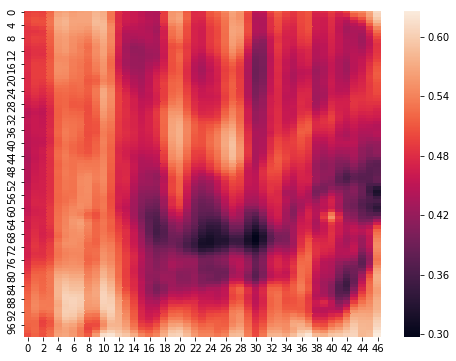

In [58]:
# If you cared to Gaussian your heat-map, but this looks to be happening along the columns not the rows
# You could also just use convolve to blur, as scipy.ndimage.convolve
#  see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve

from scipy.ndimage import gaussian_filter
data_pivot_blur = gaussian_filter(data_pivot, sigma=.9) #compare to one directly above (raw mean top vs blurred mean here)
plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot_blur)

# Begin code for interpolation for cortex data

First pick the scaling method you want to use, for this example we will select min_max within_slice scaling

In [18]:
# Could do this with 2D interpolation instead? or use your row interpretation method from the kriging program 
# that would be similar to the funciton below, but interpolate with groupby('box') instead of by slice, 
# effectively interpolating across rows. 
# we could do a different method where we apply a gaussian kernal as well (or some within-brain scaling)

In [37]:
all_slices_scaled_df_list = []

def cortex_slice_interp(scaled_slice_frame):    
    values = scaled_slice_frame.slice_min_max #HERE YOU CAN SEE WE SELECTED MIN_MAX AS THE SCALING WE WANT TO USE
    x = np.arange(0,len(scaled_slice_frame)) #this will probably want to be changed to sbox_linear_distances tho? since 
                                             # right now all of the slices have the same length
    y = values
    
    f = interpolate.interp1d(x,y)
    
    xnew = np.arange(0,99,.05) #you might to have the third value here be adjustable so each slice is interpolated differently
    ynew = f(xnew)
    
    new_frame = pd.DataFrame({'slice':slices,'new_box':xnew,'interped_values':ynew})
    #scaled_slice_frame['slice_min_max'] = minmax_scale(raw_mean)

    
    return(new_frame)
    
    
# Now want to apply the cortex_slice_interp function to all of the slices, then recombine the DataFrame    
slice_groups = slice_scale_frame.groupby('slice').groups.keys()
for slices in slice_groups: 
    this_frame = slice_scale_frame.loc[slice_scale_frame['slice'] == slices]
    
    add_frame = cortex_slice_interp(this_frame)
    
    all_slices_scaled_df_list.append(add_frame)
    
all_interped_dfs = pd.concat(all_slices_scaled_df_list)

In [38]:
# Checks to make sure this concatenated right
#len(all_interped_dfs)
#all_interped_dfs.head()

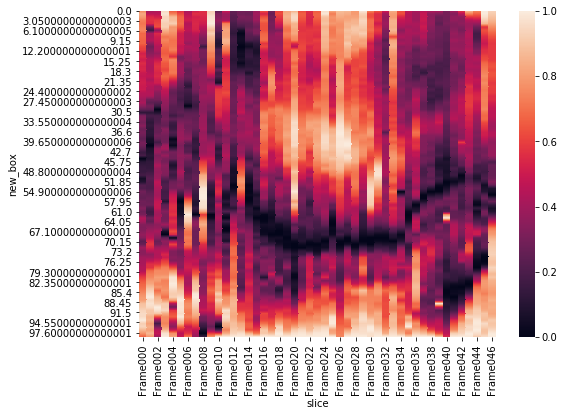

In [39]:
data_pivot = all_interped_dfs.pivot('new_box','slice','interped_values')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)